In [ ]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

#Содержание:

1.   Style Transfer
2.   Pix 2 Pix






In [ ]:
%matplotlib inline
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
# from scipy import ndimage
# import math
import numpy as np
import cv2

import copy
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1.Style transfer

In [ ]:
%cd /content/

/content


In [ ]:
%mkdir images

In [ ]:
%cd /content/images

/content/images


In [ ]:
!cp /content/gdrive/'My Drive'/sample/the-hand.jpg .
!cp /content/gdrive/'My Drive'/sample/mannequin-barcelona-mannequin-1927.jpg!Large.jpg .
!cp /content/gdrive/'My Drive'/sample/the-pool-of-tears.jpg!Large.jpg .
!cp /content/gdrive/'My Drive'/sample/the-disintegration-of-the-persistence-of-memory.jpg!Large.jpg .
!cp /content/gdrive/'My Drive'/sample/8893213_sun-moon-faces.jpg .
!cp /content/gdrive/'My Drive'/sample/paranoia-surrealist-figures.jpg!Large.jpg .
!cp /content/gdrive/'My Drive'/sample/untitled-stereoscopic-painting.jpg!Large.jpg .

In [ ]:
blue = np.uint8([[[255, 0, 0]]]) #here insert the bgr values which you want to convert to hsv
yellow = np.uint8([[[0, 179, 255]]]) #here insert the bgr values which you want to convert to hsv
hsvBlue = cv2.cvtColor(blue, cv2.COLOR_BGR2HSV)
hsvYellow = cv2.cvtColor(yellow, cv2.COLOR_BGR2HSV)
lowerBlue = hsvBlue[0][0][0] - 10, 100, 100
upperBlue = hsvBlue[0][0][0] + 10, 255, 255
lowerYellow = hsvYellow[0][0][0] - 10, 100, 100
upperYellow = hsvYellow[0][0][0] + 10, 255, 255
print(lowerBlue, upperBlue)
print(lowerYellow, upperYellow)

(110, 100, 100) (130, 255, 255)
(11, 100, 100) (31, 255, 255)


In [ ]:
# функция для получения масок по картинке

def get_faces_mask(path='/content/images/8893213_sun-moon-faces.jpg'):
    sizes = [512, 512, 256, 256, 128, 128]
    full_mask_list = []
    img_ = cv2.imread(path)
    hsv_min = np.array([11 , 100, 100])
    hsv_max = np.array([130, 255, 255])
    for size in sizes:
        # ресайзим изображение для составления картинки и получаем маски
        img = cv2.resize(img_, (size, size), interpolation = cv2.INTER_AREA)
        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img_hsv_min = np.zeros((size,size,3), dtype=np.uint8)
        img_hsv_max = np.zeros((size,size,3), dtype=np.uint8)
        img_hsv_min[...] = hsv_min
        img_hsv_max[...] = hsv_max
        curr_mask = cv2.inRange(hsv_img, hsv_min, hsv_max)
        curr_mask = curr_mask / 255     
        # добавляем маски в список масок
        mask_list_ = [np.ones_like(curr_mask) - curr_mask, curr_mask] 
        # переводим в тензор с новой осью для последующей конкатинации 
        mask_list = [torch.from_numpy(np.expand_dims(mask, axis=0)).to(dtype=torch.float) for mask in mask_list_]
        # добавляем в общий список
        full_mask_list.append(mask_list)
    return full_mask_list  


In [ ]:
# изменил размер изображения
imsize = 512
loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [ ]:
# Для стилей использовал репродукции картин Сальвадора Дали
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, dtype = torch.float)

style_img1 = image_loader("/content/images/the-hand.jpg")# as well as here
style_img2 = image_loader("/content/images/mannequin-barcelona-mannequin-1927.jpg!Large.jpg")
style_img3 = image_loader("/content/images/the-disintegration-of-the-persistence-of-memory.jpg!Large.jpg")# as well as here
style_img4 = image_loader("/content/images/the-pool-of-tears.jpg!Large.jpg")
style_img5 = image_loader("/content/images/paranoia-surrealist-figures.jpg!Large.jpg")# as well as here
style_img6 = image_loader("/content/images/untitled-stereoscopic-painting.jpg!Large.jpg")
# определяем три связки 
style_img_list = [ [style_img1, style_img2], [style_img4, style_img6], [style_img3, style_img5] ]
# определяем основную картинку 
content_img = image_loader("/content/images/8893213_sun-moon-faces.jpg")

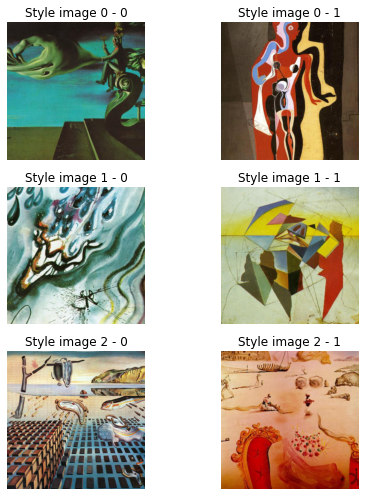

In [ ]:
unloader = transforms.ToPILImage() # тензор в кратинку  
plt.ion() 

def imshow(tensor):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    # plt.imshow(image)
    # if title is not None:
    #     plt.title(title)
    # plt.pause(0.001) 
    return image

# отрисовка картин стилей
fig, ax = plt.subplots(3, 2, figsize=(7,7))
ax = ax.ravel()
num = 0
for i, style_imgs in enumerate(style_img_list):
    for j, img in enumerate(style_imgs):
        title = 'Style image ' + str(i) + ' - ' + str(j)
        ax[num].set_title(title)
        ax[num].axis('off')
        ax[num].imshow(imshow(img))     
        num += 1
plt.tight_layout()
plt.show()


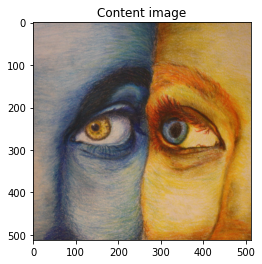

In [ ]:
# отрисовка основной картинки  
plt.imshow(imshow(content_img))
plt.title('Content image')
plt.show() 

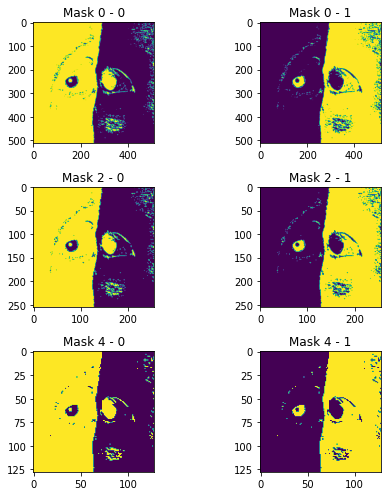

In [ ]:
full_mask_list = get_faces_mask()
# отрисовка масок - они имеют разный размер, это видно по осям
fig, ax = plt.subplots(3, 2, figsize=(7,7))
ax = ax.ravel()
num = 0
for i in range(0, len(full_mask_list), 2):
    for j, mask in enumerate(full_mask_list[i]):
        title = 'Mask ' + str(i) + ' - ' + str(j)
        ax[num].set_title(title)
        ax[num].imshow(imshow(full_mask_list[i][j]))     
        num += 1
plt.tight_layout()
plt.show()

In [ ]:
# Класс для Лосс 
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
        self.loss = F.mse_loss(self.target, self.target )#to initialize with something

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
# матрица Грамма
def gram_matrix(input):
    batch_size , h, w, f_map_num = input.size()  # batch size(=1)
    # b=number of feature maps
    # (h,w)=dimensions of a feature map (N=h*w)
    features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL
    # features = input.view(batch_size * f_map_num, -1)
    G = torch.mm(features, features.t())  # compute the gram product
    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(batch_size * h * w * f_map_num)

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        # self.mean = torch.tensor(mean.clone().detach()).view(-1, 1, 1)
        # self.std = torch.tensor(std.clone().detach()).view(-1, 1, 1)
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
cnn

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [ ]:
# StyleLoss для работы со списками масок и стилей

class StyleLoss(nn.Module):
        def __init__(self, target_list, mask_list):
            super(StyleLoss, self).__init__()
            self.target_list = target_list
            self.mask_list = mask_list
            self.loss = F.mse_loss(gram_matrix(self.target_list[0]).detach(), gram_matrix(self.target_list[0]).detach())

        def forward(self, input):
            _ , f_map_num, _, _ = input.size()  # batch size(=1)          
            # конкатинируем маски по количеству фичей 
            # добавляем еще одну ось размера батча
            # вычисляем матрицу Грамма для маски
            # вычисляем матрицу Грамма для таргета
            # считаем Лосс
            self.loss = 0
            for i, mask in enumerate(self.mask_list):
                list_cur_mask = [mask for _ in range(0, f_map_num)]
                cur_mask = torch.cat((list_cur_mask),0).unsqueeze(0).to(device) 
                cur_input = input * cur_mask
                G_M = gram_matrix(cur_input)
                G_T = gram_matrix(self.target_list[i]).detach()
                self.loss += F.mse_loss(G_M, G_T)
                
            return input

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img_list,
                                   content_img,
                                   full_mask_list,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_list = [model(img).detach() for img in style_img_list]
                # в StyleLoss передаём маски по размеру слоя           
                ind = style_layers.index(name)            
                style_loss = StyleLoss(target_list, full_mask_list[ind])
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        style_img_list,
                        full_mask_list,
                        content_img,
                        input_img, num_steps=450,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img_list, content_img, full_mask_list)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()
                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight
                loss = style_score + content_score
  
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

In [ ]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            style_img_list[0], full_mask_list, content_img, input_img)
img = imshow(output)
img.save('picture' + '_' + '0' +'.png')

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 21.253561 Content Loss: 13.659233

run [100]:
Style Loss : 10.848947 Content Loss: 12.825948

run [150]:
Style Loss : 8.584455 Content Loss: 12.154699

run [200]:
Style Loss : 7.311430 Content Loss: 12.017434

run [250]:
Style Loss : 8.098387 Content Loss: 13.637346

run [300]:
Style Loss : 8.405278 Content Loss: 13.313101

run [350]:
Style Loss : 6.594069 Content Loss: 12.228138

run [400]:
Style Loss : 6.412032 Content Loss: 11.982727

run [450]:
Style Loss : 7.411974 Content Loss: 12.150702



In [ ]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            style_img_list[1], full_mask_list, content_img, input_img,
                            num_steps = 400)
img = imshow(output)
img.save('picture' + '_' + '1' +'.png')

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 15.630198 Content Loss: 14.790984

run [100]:
Style Loss : 6.151111 Content Loss: 13.395643

run [150]:
Style Loss : 4.116426 Content Loss: 12.344482

run [200]:
Style Loss : 3.271508 Content Loss: 11.708700

run [250]:
Style Loss : 2.833215 Content Loss: 11.321795

run [300]:
Style Loss : 2.560741 Content Loss: 11.143897

run [350]:
Style Loss : 2.565175 Content Loss: 10.901935

run [400]:
Style Loss : 2.451099 Content Loss: 11.080111



In [ ]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            style_img_list[2], full_mask_list, content_img, input_img,
                            num_steps = 450)
img = imshow(output)
img.save('picture' + '_' + '2' +'.png')

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 29.402300 Content Loss: 27.371141

run [100]:
Style Loss : 11.696968 Content Loss: 26.374710

run [150]:
Style Loss : 7.368453 Content Loss: 24.851643

run [200]:
Style Loss : 5.751937 Content Loss: 23.796642

run [250]:
Style Loss : 5.109547 Content Loss: 23.331818

run [300]:
Style Loss : 11.637155 Content Loss: 22.116848

run [350]:
Style Loss : 70.436127 Content Loss: 22.698700

run [400]:
Style Loss : 7.099566 Content Loss: 22.796600

run [450]:
Style Loss : 9.899312 Content Loss: 25.862022



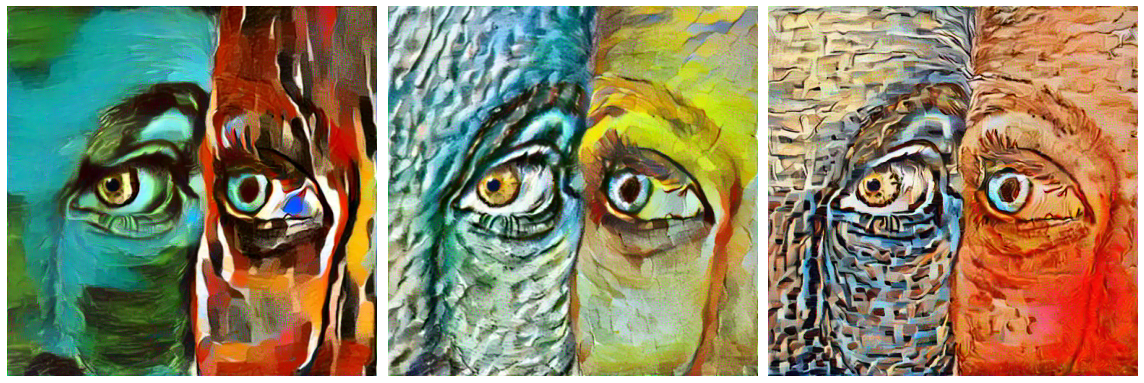

In [ ]:
# выводим изображения 
picture_list = ["picture_0.png", "picture_1.png", "picture_2.png"]
fig, ax = plt.subplots(1, 3, figsize=(16,16))
ax = ax.ravel()
for i, picture in enumerate(picture_list):
    img = Image.open(picture)  
    ax[i].axis('off')
    ax[i].imshow(img)     
plt.tight_layout()
plt.show()

#2.Pix 2 Pix

В качестве датасета использовал датасет иллюстраций к рассказам Диккенса на Kaggle 

Ссылка на датасет [здесь](https://www.kaggle.com/elibooklover/victorian400)

In [ ]:
from keras.layers import Input, Add, Conv2DTranspose, Conv2D, MaxPooling2D, Concatenate
from keras.layers import BatchNormalization, Activation, LeakyReLU
from keras.initializers import RandomNormal
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf
import os
from pathlib import Path
import glob
import cv2
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content

/content


In [ ]:
!cp /content/gdrive/'My Drive'/dickens/dickens.zip .
!unzip dickens.zip

In [ ]:
# Модель генератора (пробывал сделать похоже на D-Linknet)
# с закомиченными слоями и без, результат примерно одинаков
def generator():

    init = RandomNormal(stddev=0.02)
    inp = Input(shape=(256, 256, 3))

    conv_1_1 = Conv2D(32, (3, 3), padding='same', kernel_initializer=init)(inp)
    norm_1_1 = BatchNormalization(momentum=0.8)(conv_1_1)
    act_1_1 = LeakyReLU(alpha=0.2)(norm_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same', kernel_initializer=init)(act_1_1)
    norm_1_2 = BatchNormalization(momentum=0.8)(conv_1_2)
    act_1_2 = LeakyReLU(alpha=0.2)(norm_1_2)        
    pool_1 = MaxPooling2D(2)(act_1_2)

    conv_res_1 = Conv2D(32, (1, 1), strides=2, padding='same', kernel_initializer=init)(inp)
    res_1 = Add()([conv_res_1, pool_1])
    norm_res_1 = BatchNormalization(momentum=0.8)(res_1)
    act_res_1 = LeakyReLU(alpha=0.2)(norm_res_1)

    conv_2_1 = Conv2D(64, (3, 3), padding='same', kernel_initializer=init)(act_res_1)
    norm_2_1 = BatchNormalization(momentum=0.8)(conv_2_1)
    act_2_1 = LeakyReLU(alpha=0.2)(norm_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same', kernel_initializer=init)(act_2_1)
    norm_2_2 = BatchNormalization(momentum=0.8)(conv_2_2)
    act_2_2 = LeakyReLU(alpha=0.2)(norm_2_2)
    pool_2 = MaxPooling2D(2)(act_2_2)

    conv_res_2 = Conv2D(64, (1, 1), strides=2, padding='same', kernel_initializer=init)(act_res_1)
    res_2 = Add()([conv_res_2, pool_2])
    norm_res_2 = BatchNormalization(momentum=0.8)(res_2)
    act_res_2 = LeakyReLU(alpha=0.2)(norm_res_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same', kernel_initializer=init)(act_res_2)
    norm_3_1 = BatchNormalization(momentum=0.8)(conv_3_1)
    act_3_1 = LeakyReLU(alpha=0.2)(norm_3_1)
    conv_3_2 = Conv2D(128, (3, 3), padding='same', kernel_initializer=init)(act_3_1)
    norm_3_2 = BatchNormalization(momentum=0.8)(conv_3_2)
    act_3_2 = LeakyReLU(alpha=0.2)(norm_3_2)
    pool_3 = MaxPooling2D(2)(act_3_2)

    conv_res_3 = Conv2D(128, (1, 1), strides=2, padding='same', kernel_initializer=init)(act_res_2)
    res_3 = Add()([conv_res_3, pool_3])
    norm_res_3 = BatchNormalization(momentum=0.8)(res_3)
    act_res_3 = LeakyReLU(alpha=0.2)(norm_res_3)

    conv_4_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer=init)(act_res_3)
    norm_4_1 = BatchNormalization(momentum=0.8)(conv_4_1)
    act_4_1 = LeakyReLU(alpha=0.2)(norm_4_1)
    conv_4_2 = Conv2D(256, (3, 3), padding='same', kernel_initializer=init)(act_4_1)
    norm_4_2 = BatchNormalization(momentum=0.8)(conv_4_2)
    act_4_2 = LeakyReLU(alpha=0.2)(norm_4_2)
    pool_4 = MaxPooling2D(2)(act_4_2)

    conv_res_4 = Conv2D(256, (1, 1), strides=2, padding='same', kernel_initializer=init)(act_res_3)
    res_4 = Add()([conv_res_4, pool_4])
    norm_res_4 = BatchNormalization(momentum=0.8)(res_4)
    act_res_4 = LeakyReLU(alpha=0.2)(norm_res_4)

    bottel_conv = Conv2D(512, (3, 3), padding='same', kernel_initializer=init)(act_res_4)
    bottel_norm = BatchNormalization(momentum=0.8)(bottel_conv)
    bottel_act = LeakyReLU(alpha=0.2)(bottel_norm)

    conv_up_1 = Conv2D(256, (1, 1), padding='same', kernel_initializer=init)(bottel_act)
    res_up_1 = Add()([conv_up_1, act_res_4])
    trans_up_1 = Conv2DTranspose(256,(3,3),(2,2),padding='same', kernel_initializer=init)(res_up_1)
    norm_up_1 = BatchNormalization(momentum=0.8)(trans_up_1)
    act_up_1 = LeakyReLU(alpha=0.2)(norm_up_1)
    # conv_up_1_2 = Conv2D(256, (3, 3), padding='same', kernel_initializer=init)(act_up_1)
    # norm_up_1_2 = BatchNormalization(momentum=0.8)(conv_up_1_2)
    # act_up_1_2 = LeakyReLU(alpha=0.2)(norm_up_1_2)

    conv_up_2 = Conv2D(128, (1, 1), padding='same', kernel_initializer=init)(act_up_1)
    res_up_2 = Add()([conv_up_2, act_res_3])
    trans_up_2 = Conv2DTranspose(128,(3,3),(2,2),padding='same', kernel_initializer=init)(res_up_2)
    norm_up_2 = BatchNormalization(momentum=0.8)(trans_up_2)
    act_up_2 = LeakyReLU(alpha=0.2)(norm_up_2)
    # conv_up_2_2 = Conv2D(128, (3, 3), padding='same', kernel_initializer=init)(act_up_2)
    # norm_up_2_2 = BatchNormalization(momentum=0.8)(conv_up_2_2)
    # act_up_2_2 = LeakyReLU(alpha=0.2)(norm_up_2_2)

    conv_up_3 = Conv2D(64, (1, 1), padding='same', kernel_initializer=init)(act_up_2)
    res_up_3 = Add()([conv_up_3, act_res_2])
    trans_up_3 = Conv2DTranspose(64,(3,3),(2,2),padding='same', kernel_initializer=init)(res_up_3)
    norm_up_3 = BatchNormalization(momentum=0.8)(trans_up_3)
    act_up_3 = LeakyReLU(alpha=0.2)(norm_up_3)
    # conv_up_3_2 = Conv2D(64, (3, 3), padding='same', kernel_initializer=init)(act_up_3)
    # norm_up_3_2 = BatchNormalization(momentum=0.8)(conv_up_3_2)
    # act_up_3_2 = LeakyReLU(alpha=0.2)(norm_up_3_2)

    conv_up_4 = Conv2D(32, (1, 1), padding='same', kernel_initializer=init)(act_up_3)
    res_up_4 = Add()([conv_up_4, act_res_1])
    trans_up_4 = Conv2DTranspose(32,(3,3),(2,2),padding='same', kernel_initializer=init)(res_up_4)
    norm_up_4 = BatchNormalization(momentum=0.8)(trans_up_4)
    act_up_4 = LeakyReLU(alpha=0.2)(norm_up_4)
    # conv_up_4_2 = Conv2D(32, (3, 3), padding='same', kernel_initializer=init)(act_up_4)
    # norm_up_4_2 = BatchNormalization(momentum=0.8)(conv_up_4_2)
    # act_up_4_2 = LeakyReLU(alpha=0.2)(norm_up_4_2)

    res = Conv2D(3, (3, 3), padding='same')(act_up_4)
    act_res = Activation('tanh')(res)
        
    model = Model(inputs=inp, outputs=act_res)
    opt = Adam(lr=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy')

    return model

In [ ]:
# Модель дискриминатора
# Копирует первые блоки генератора но без скипов

def discriminator(image_shape):

    init = RandomNormal(stddev=0.02)

    in_src_image = Input(shape=image_shape)
    in_target_image = Input(shape=image_shape)
  
    merged = Concatenate()([in_src_image, in_target_image])

    conv_1_1 = Conv2D(32, (3, 3), padding='same', kernel_initializer=init)(merged)
    norm_1_1 = BatchNormalization(momentum=0.8)(conv_1_1)
    act_1_1 = LeakyReLU(alpha=0.2)(norm_1_1)
    pool_1 = MaxPooling2D(2)(act_1_1)

    conv_2_1 = Conv2D(64, (3, 3), padding='same', kernel_initializer=init)(pool_1)
    norm_2_1 = BatchNormalization(momentum=0.8)(conv_2_1)
    act_2_1 = LeakyReLU(alpha=0.2)(norm_2_1)
    pool_2 = MaxPooling2D(2)(act_2_1)

    conv_3_1 = Conv2D(128, (3, 3), padding='same', kernel_initializer=init)(pool_2)
    norm_3_1 = BatchNormalization(momentum=0.8)(conv_3_1)
    act_3_1 = LeakyReLU(alpha=0.2)(norm_3_1)
    pool_3 = MaxPooling2D(2)(act_3_1)

    conv_4_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer=init)(pool_3)
    norm_4_1 = BatchNormalization(momentum=0.8)(conv_4_1)
    act_4_1 = LeakyReLU(alpha=0.2)(norm_4_1)
    conv_5_1 = Conv2D(1, (1,1), padding='same', kernel_initializer=init)(act_4_1)
     
    res = Activation('sigmoid')(conv_5_1)
  
    model = Model(inputs = [in_src_image, in_target_image], outputs = res)
    opt = Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'], loss_weights=[1, 100])

    return model

In [ ]:
# определяем пути к датасету и формируем его
GRAY_DIR = Path('/content/dickens/gray')
COLOR_DIR = Path('/content/dickens/resized')

def get_images(path):
    files = list(glob.glob(os.path.join(path,'*.png')))
    images = []
    for file in files:
        img = cv2.imread(file)
        images += [img]  
    return np.array(images) / 127.5 - 1

dataset = [get_images(GRAY_DIR), get_images(COLOR_DIR)] 

In [ ]:
class MyGun():
    def __init__(self, model_gen, model_dis, dataset=dataset):
        self.dataset = dataset
        self.model_gen = model_gen
        self.model_dis = model_dis
        self.dis_out_size = self.model_dis.output.shape[1]
        self.gun = self.get_gun()

    def get_gun(self):
        # отключаем обучение дискриминатора
        self.model_dis.trainable = False
        inp = Input(shape=(256, 256, 3))          
        # создаем общую модель
        gen_pred = self.model_gen(inp)
        dis_pred = self.model_dis([inp, gen_pred])
        model = Model(inp, [dis_pred, gen_pred])

        opt = Adam(lr=0.0001, beta_1=0.5)
        model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
        return model

    def train(self, batch_size=10, epochs=100, rate=1):
        # при rate=1 размер батча для дескриминатора остаётся прежним 
        bat = int(len(self.dataset[0]) // batch_size)
        steps = bat * epochs
        for i in range(steps):
            # тренируем дискрименатор на обучающем наборе
            ix = np.random.randint(0, self.dataset[0].shape[0], batch_size)  
            # уменьшим размера батча для обучения дескриминатора через 
            # параметр rate()
            batch_size_dis = int(batch_size // rate)
            ix_dis = np.random.randint(0, ix.shape[0], batch_size_dis)

            y_real = np.ones((batch_size, self.dis_out_size, self.dis_out_size, 1))
            y_real_dis = np.ones((batch_size_dis, self.dis_out_size, self.dis_out_size, 1))

            d_loss_real = self.model_dis.train_on_batch([ self.dataset[0][ix_dis], self.dataset[1][ix_dis] ], y_real_dis)
            # получаем батч фейков от генератора
            x_fake_dis = self.model_gen.predict(self.dataset[0][ix_dis])
            # тренируем дискрименатор на фейковом наборе
            y_fake_dis = np.zeros((batch_size_dis, self.dis_out_size, self.dis_out_size, 1))
            d_loss_fake = self.model_dis.train_on_batch([ self.dataset[0][ix_dis], x_fake_dis], y_fake_dis)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # тренируем весь ган на полном батче
            g_loss, _, _ = self.gun.train_on_batch(self.dataset[0][ix], [y_real, self.dataset[1][ix] ])
            if (i + 1) % 50 == 0:
                print('>> step %d d_loss = %.3f d_acc = %.3f g_loss = %.3f >>' % (i+1, d_loss[0], 100*d_loss[1], g_loss))
            if (i + 1) % (bat * 50) == 0:
                self.save_show_result(i)

    def save_show_result(self, step, samples=3, flag=1, im_ids=[]):
        # получаем случайные картинки из датасета
        if len(im_ids) == 0:
            ix = np.random.randint(0, self.dataset[0].shape[0], samples)  
        else:
            ix = np.array(im_ids)    
        x_gray = self.dataset[0][ix]
        x_color = self.dataset[1][ix]
        # получаем фейковую картинку от генератора
        x_fake = self.model_gen.predict(self.dataset[0][ix])
        img_dict = {'Gray': x_gray, 'Color': x_color, 'Fake': x_fake}
        fig, ax = plt.subplots(3, 3, figsize=(9,9))
        ax = ax.ravel()
        num = 0 
        for key, imgs in img_dict.items():
            imgs = (imgs + 1) / 2.0
            for j, img in enumerate(imgs):
                ax[num].set_title(key)
                ax[num].axis('off')
                ax[num].imshow(img)
                num += 1     
        plt.tight_layout()
        if flag == 1:
            file_name = 'pic_%04d.png' % (step+1)
            plt.savefig(file_name)
            plt.close()
        elif flag == 0:
            plt.show()    

                

In [ ]:
# Решил попробывать узнать как скажется итоговое качество модели генератора
# если дискриминатор при обучении тренировать батчами размером меньше
# чем размер батча при тренировке всей модели гана.
# идея была меньше учить дискриминатор чтобы генератор не переобучился на 
# дискриминаторе

# Тренировка сети одинакового размера батчами гана и дискриминатора
my_gan1 = MyGun(generator(), discriminator((256,256,3)))
my_gan1.train(epochs=200, rate=1)

>> step 50 d_loss = 0.672 d_acc = 61.284 g_loss = 21.153 >>
>> step 100 d_loss = 0.638 d_acc = 72.876 g_loss = 15.341 >>
>> step 150 d_loss = 0.606 d_acc = 85.537 g_loss = 12.364 >>
>> step 200 d_loss = 0.589 d_acc = 83.301 g_loss = 15.602 >>
>> step 250 d_loss = 0.580 d_acc = 80.566 g_loss = 11.205 >>
>> step 300 d_loss = 0.541 d_acc = 91.030 g_loss = 11.947 >>
>> step 350 d_loss = 0.520 d_acc = 87.144 g_loss = 13.472 >>
>> step 400 d_loss = 0.445 d_acc = 96.348 g_loss = 12.129 >>
>> step 450 d_loss = 0.423 d_acc = 95.972 g_loss = 10.412 >>
>> step 500 d_loss = 0.389 d_acc = 98.301 g_loss = 11.267 >>
>> step 550 d_loss = 0.346 d_acc = 98.208 g_loss = 13.290 >>
>> step 600 d_loss = 0.347 d_acc = 98.755 g_loss = 10.990 >>
>> step 650 d_loss = 0.392 d_acc = 94.819 g_loss = 12.466 >>
>> step 700 d_loss = 0.275 d_acc = 99.409 g_loss = 9.626 >>
>> step 750 d_loss = 0.306 d_acc = 98.149 g_loss = 12.325 >>
>> step 800 d_loss = 0.292 d_acc = 98.521 g_loss = 11.311 >>
>> step 850 d_loss = 0.297

In [ ]:
# Тренировка сети размер батча дискриминатора в два раза меньше чем генератора
my_gan2 = MyGun(generator(), discriminator((256,256,3)))
my_gan2.train(epochs=200, rate=2)

>> step 50 d_loss = 0.674 d_acc = 60.293 g_loss = 17.673 >>
>> step 100 d_loss = 0.638 d_acc = 73.545 g_loss = 13.668 >>
>> step 150 d_loss = 0.631 d_acc = 78.760 g_loss = 15.194 >>
>> step 200 d_loss = 0.613 d_acc = 79.746 g_loss = 14.803 >>
>> step 250 d_loss = 0.598 d_acc = 80.986 g_loss = 11.928 >>
>> step 300 d_loss = 0.564 d_acc = 87.422 g_loss = 11.480 >>
>> step 350 d_loss = 0.558 d_acc = 86.787 g_loss = 14.356 >>
>> step 400 d_loss = 0.501 d_acc = 93.594 g_loss = 10.538 >>
>> step 450 d_loss = 0.468 d_acc = 96.709 g_loss = 14.192 >>
>> step 500 d_loss = 0.430 d_acc = 97.559 g_loss = 11.141 >>
>> step 550 d_loss = 0.451 d_acc = 95.654 g_loss = 11.988 >>
>> step 600 d_loss = 0.379 d_acc = 99.023 g_loss = 10.547 >>
>> step 650 d_loss = 0.398 d_acc = 97.666 g_loss = 11.615 >>
>> step 700 d_loss = 0.386 d_acc = 97.764 g_loss = 12.639 >>
>> step 750 d_loss = 0.326 d_acc = 98.730 g_loss = 12.225 >>
>> step 800 d_loss = 0.355 d_acc = 97.275 g_loss = 14.538 >>
>> step 850 d_loss = 0.29

In [ ]:
# Тренировка сети размер батча дискриминатора в три раза меньше чем генератора
my_gan3 = MyGun(generator(), discriminator((256,256,3)))
my_gan3.train(epochs=200, rate=3)

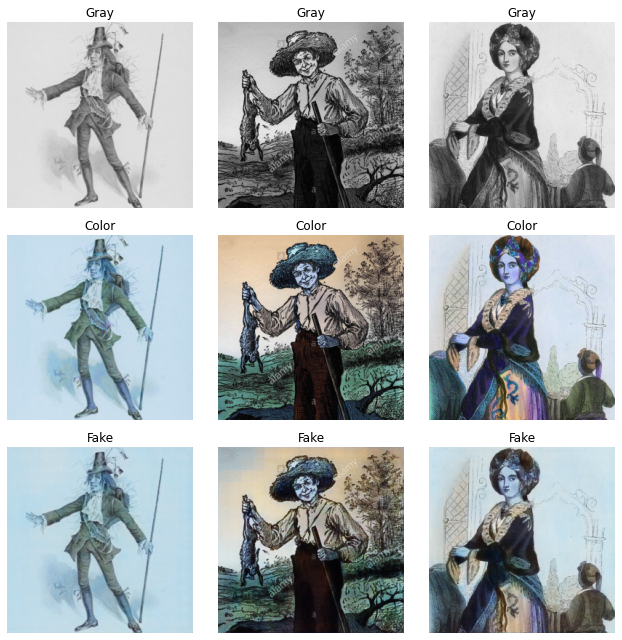

In [ ]:
# Сравним модели давая на вход одни и те же картинки 
# Это фейки первой модели с одинаковым размером выборки
my_gan1.save_show_result(step=1,flag=0,im_ids=[122,43,16])

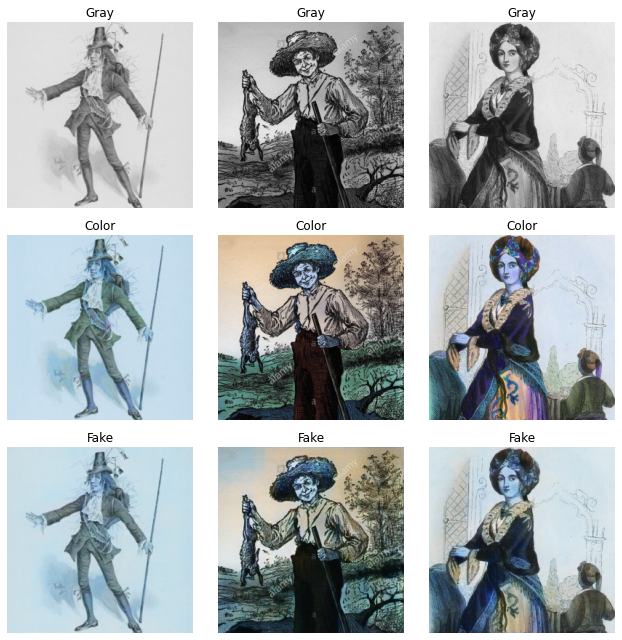

In [ ]:
# Это фейки второй модели с размером выборки дискриминатора меньшей в 2 раза
my_gan2.save_show_result(step=1,flag=0,im_ids=[122,43,16])

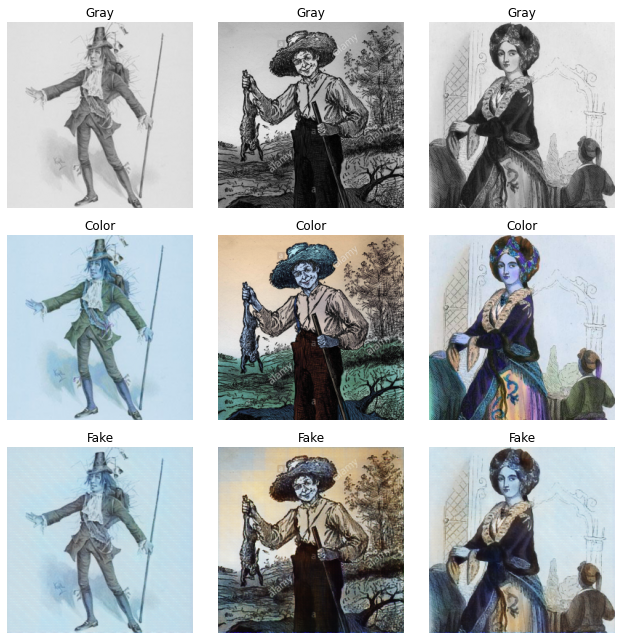

In [ ]:
# Это фейки третьей модели с размером выборки дискриминатора меньшей в 3 раза
my_gan3.save_show_result(step=1,flag=0,im_ids=[122,43,16])

In [ ]:
# Заметно что на фейках второй модели чуть ярче цвета(юбка женщины третья картинка) 
# Вообще при обучениеи у втораой модельи gLoss более равномерно снижался
# и в конце стал чуть ниже чем у первой.
# Получается что в принципе снижение размера выборки для дискриминатора
# дало положительный результат для обучения гана.
# Однако стоит заметить что размер итоговой выборки для дискриминатора не
# должен быть слишком мал. Так например при тренировке данной модели гана уменьшение размера 
# выборки для дискриминатора в три раза наоборот отрицательно сказалось на
# общих результатах.

